In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


In [2]:
#Implementamos la estructura de la NN
class NeuralNet(nn.Module):
    def __init__(self, hidden_size, output_size=1,input_size=1):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.Tanh()
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.Tanh()
        self.l3 = nn.Linear(hidden_size, hidden_size)
        self.relu3 = nn.Tanh()
        self.l4 = nn.Linear(hidden_size, hidden_size)
        self.relu4 = nn.Tanh()
        self.l5 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.l1(x)
        out = self.relu1(out)
        out = self.l2(out)
        out = self.relu2(out)
        out = self.l3(out)
        out = self.relu3(out)
        out = self.l4(out)
        out = self.relu4(out)
        out = self.l5(out)
        
        return out

In [3]:
#Creamos el criterio de la funcion L_Data
criterion = nn.MSELoss()

# Define la funcion de costo y condiciones iniciales
def initial_condition_loss(y, target_value):
    return nn.MSELoss()(y, target_value)

In [6]:
# Vector de tiempo como entrada de la NN
t_numpy = np.arange(0, 1+0.01, 0.001, dtype=np.float32)
t = torch.from_numpy(t_numpy).reshape(len(t_numpy), 1)
t.requires_grad_(True)


g = 9.81
k = 10
m = 5 
# Iniciamos las neuronas
model = NeuralNet(hidden_size=128)

# Costo y omptimizador
learning_rate = 0.00001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# epocas
num_epochs = int(25000)

# Guardamos valores de la funcion de costo y las epocas
loss_values = []
epoch_values = []


### Ajustar el paso de epsilon al mismo paso del dominio

In [7]:
for epoch in range(num_epochs):

    
    epsilon = torch.normal(0,0.001, size=(len(t),1)).float()
    t_train = t + epsilon

    # Forward pass
    y_pred = model(t_train)

    # Caalcular la derivada del forward pass
    dy_dt = torch.autograd.grad(y_pred, 
                                t_train, 
                                grad_outputs=torch.ones_like(y_pred), 
                                create_graph=True)[0]
    d2y_dt2 = torch.autograd.grad(dy_dt, 
                                t_train, 
                                grad_outputs=torch.ones_like(dy_dt), 
                                create_graph=True)[0]
    

    # Funcion física
    loss_DE = criterion(d2y_dt2 + g + (k/m) * dy_dt, torch.zeros_like(d2y_dt2)) 

    # Condicion inicial 
    loss_IC = initial_condition_loss(model(torch.tensor([[0.0]])), 
                                     torch.tensor([[20.0]]))

    loss = loss_DE + loss_IC

    # Backward pass 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # Actualizamos L y epocas
    loss_values.append(loss.item())
    epoch_values.append(epoch)

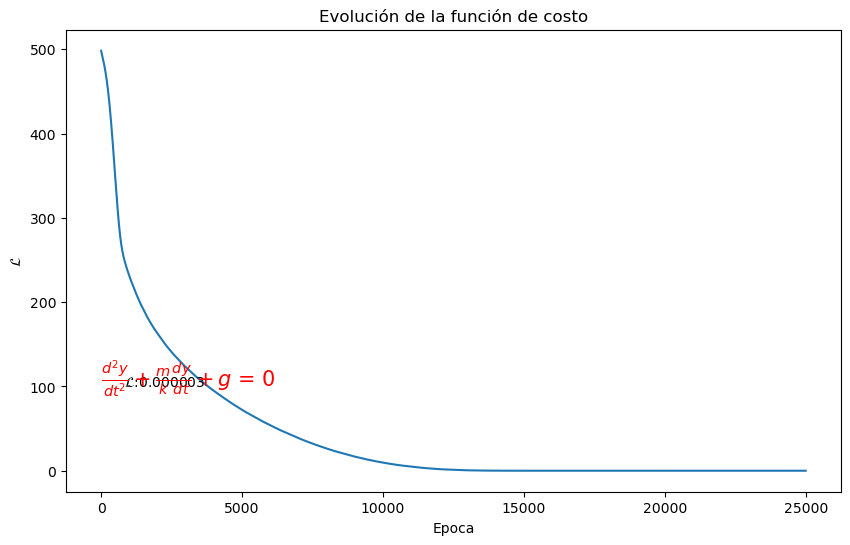

In [9]:
# Ploteamos L vs Epocas
plt.figure(figsize=(10, 6))
plt.plot(epoch_values, loss_values)
plt.xlabel('Epoca')
plt.ylabel(r'$\mathcal{L}$')
plt.title('Evolución de la función de costo')

# Añadir el valor final de la función de costo como texto en la gráfica
final_loss = loss_values[-1]
plt.text(800,100, r'$\mathcal{L}$:'+f'{final_loss:.6f}')#, verticalalignment='bottom')
plt.text(12, 100, r'$\frac{d^2y}{dt^2}+\frac{m}{k}\frac{dy}{dt}+g$ = 0', fontsize=15, color='r')
plt.savefig('lossCLR.png')
plt.show()


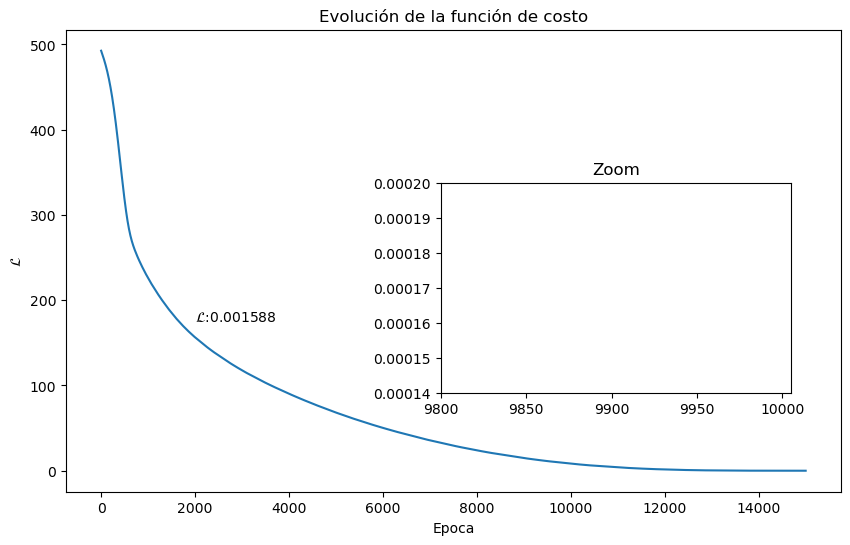

In [7]:
# Ploteamos L vs Epocas
plt.figure(figsize=(10, 6))

# Crear el eje principal
plt.subplot(1, 1, 1)

# Graficar la función de costo en el eje principal
plt.plot(epoch_values, loss_values)
plt.xlabel('Epoca')
plt.ylabel(r'$\mathcal{L}$')
plt.title('Evolución de la función de costo')

# Añadir el valor final de la función de costo como texto en el eje principal
final_loss = loss_values[-1]
plt.text(2000, 175, r'$\mathcal{L}$:' + f'{final_loss:.6f}')  # Ajustar las coordenadas según sea necesario

# Crear un nuevo eje para el zoom
left, bottom, width, height = [0.5, 0.275, 0.35, 0.35]  # Definir las coordenadas y el tamaño del nuevo eje
ax_zoom = plt.gcf().add_axes([left, bottom, width, height])

# Graficar la función de costo en el eje de zoom
ax_zoom.plot(epoch_values, loss_values)

ax_zoom.set_title('Zoom')
ax_zoom.set_xlim(9800, 10005)  # Establecer los límites x para la región de interés
ax_zoom.set_ylim(0.00014, 0.0002)  # Establecer los límites y para la región de interés

plt.show()


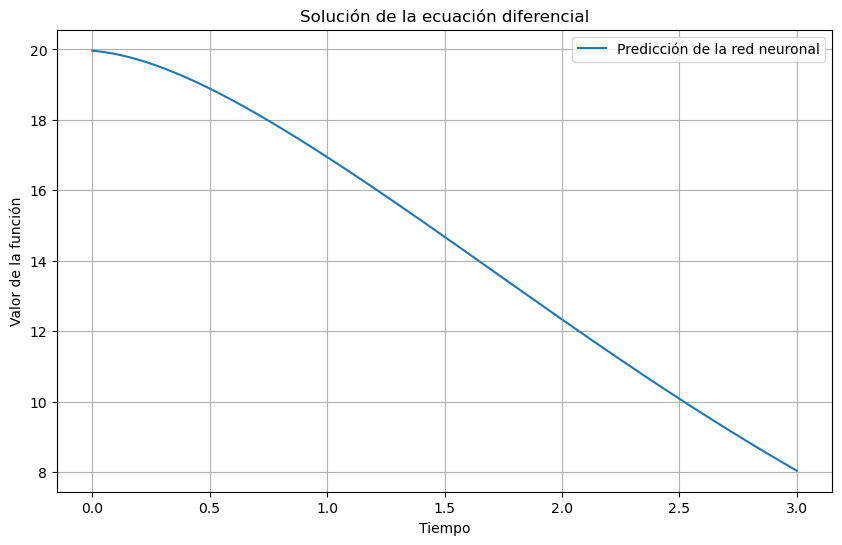

In [8]:

# Genera puntos de tiempo para evaluar la solución
t_test = torch.linspace(0, 3, 3001).reshape(-1, 1)

# Evalúa la red neuronal en los puntos de tiempo de prueba
with torch.no_grad():
    y_pred_test = model(t_test)

# Gráfica de la solución predicha por la red neuronal
plt.figure(figsize=(10, 6))
plt.plot(t_test.numpy(), y_pred_test.numpy(), label='Predicción de la red neuronal')
plt.xlabel('Tiempo')
plt.ylabel('Valor de la función')
plt.title('Solución de la ecuación diferencial')
plt.legend()
plt.grid(True)
plt.show()


### Solución con el método de Euler:

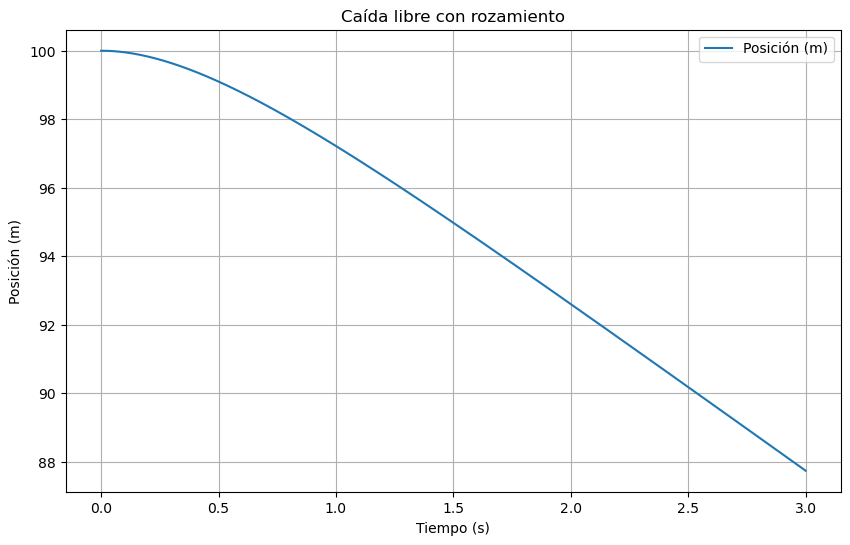

In [9]:
m = 5  # kg
nu = 10  # Coeficiente de rozamiento
y0 = 100  # m
v0 = 0  # m/s
t_max = 3  # s
dt = 0.001  # Paso de tiempo

# Número de pasos de tiempo
num_steps = int(t_max / dt)

# Arrays para almacenar los valores de posición y velocidad
y_values = np.zeros(num_steps+1)
v_values = np.zeros(num_steps+1)

# Condiciones iniciales
y_values[0] = y0
v_values[0] = v0

# Método de Euler para resolver la ecuación diferencial
for i in range(num_steps):
    y_values[i+1] = y_values[i] + v_values[i] * dt
    v_values[i+1] = v_values[i] + (-g - nu/m * v_values[i]) * dt

# Plot
import matplotlib.pyplot as plt

# Eje temporal
t_values = np.linspace(0, t_max, num_steps+1)

# Graficar posición respecto al tiempo
plt.figure(figsize=(10, 6))
plt.plot(t_values, y_values, label='Posición (m)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Posición (m)')
plt.title('Caída libre con rozamiento')
plt.grid(True)
plt.legend()
plt.show()


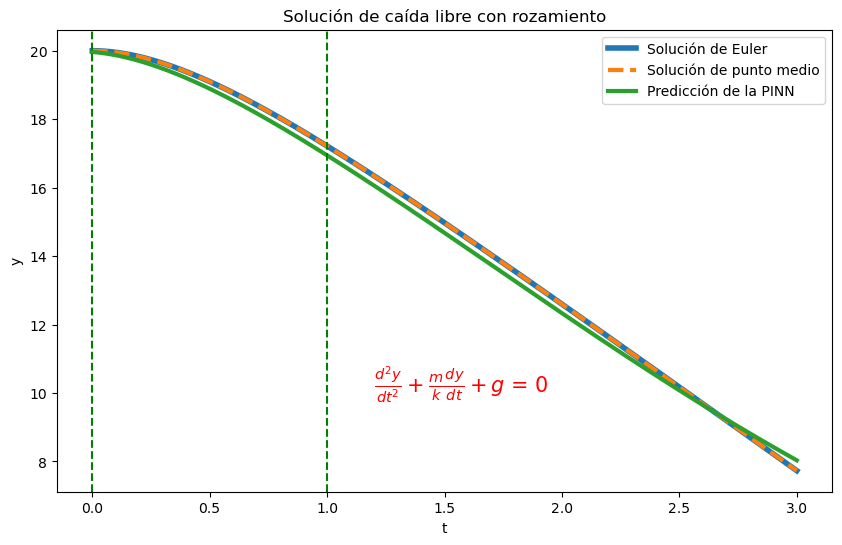

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Constantes
g = 9.81  # m/s^2
m = 5  # kg
nu = 10  # Coeficiente de rozamiento
y0 = 20  # m
v0 = 0  # m/s
t_max = 3  # s
dt = 0.001  # Paso de tiempo

# Método de Euler para solución numérica
def euler_method():
    num_steps = int(t_max / dt)
    y_values = np.zeros(num_steps + 1)
    v_values = np.zeros(num_steps + 1)
    y_values[0] = y0
    v_values[0] = v0
    for i in range(num_steps):
        y_values[i + 1] = y_values[i] + v_values[i] * dt
        v_values[i + 1] = v_values[i] + (-g - nu / m * v_values[i]) * dt
    return y_values

# Método de punto medio para solución numérica
def midpoint_method():
    num_steps = int(t_max / dt)
    y_values = np.zeros(num_steps + 1)
    v_values = np.zeros(num_steps + 1)
    y_values[0] = y0
    v_values[0] = v0
    for i in range(num_steps):
        v_half = v_values[i] + (-g - nu / m * v_values[i]) * dt / 2
        y_values[i + 1] = y_values[i] + v_half * dt
        v_values[i + 1] = v_half + (-g - nu / m * v_half) * dt / 2
    return y_values

# Generar puntos de tiempo para evaluar las soluciones
t_values = np.linspace(0, t_max, int(t_max / dt) + 1)

# Solución numérica mediante Euler
y_euler = euler_method()

# Solución numérica mediante el método de punto medio
y_midpoint = midpoint_method()

# Generar puntos de tiempo para evaluar la solución de la red neuronal
t_test = np.linspace(0, t_max, len(y_euler))
# Evalúa la red neuronal en los puntos de tiempo de prueba
with torch.no_grad():
    t_test_tensor = torch.tensor(t_test, dtype=torch.float32)  # Convertir a tipo de datos float32
    y_pred_test = model(t_test_tensor.reshape(-1, 1))

# Gráfica de la solución predicha por la red neuronal, Euler y método de punto medio
plt.figure(figsize=(10, 6))
plt.plot(t_test, y_euler, lw=4, label='Solución de Euler')
plt.plot(t_test, y_midpoint, lw=3, linestyle='--',label='Solución de punto medio')
plt.plot(t_test, y_pred_test.numpy(), lw=3, label='Predicción de la PINN')
plt.xlabel('t')
plt.ylabel('y')
plt.title('Solución de caída libre con rozamiento')
plt.axvline(x=0, color='g', linestyle='--')  # Línea vertical en t = 0
plt.axvline(x=1, color='g', linestyle='--')  # Línea vertical en t = 0
plt.text(1.2, 10, r'$\frac{d^2y}{dt^2}+\frac{m}{k}\frac{dy}{dt}+g$ = 0', fontsize=15, color='r')
plt.legend()
plt.savefig('CaidaConRozamiento2.png')
plt.show()
